# Exploring the Impact of Age and Gameplay Duration on Subscription Behavior

In [1]:
# Run before loading the rest of the project

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Sets seed for the project, run before running the rest of the project
set.seed(2025)

- A set seed is used to ensure reproducibility. Every time an R kernel is started, it generates a new seed. This results in massive varience between runs. Having a seed set prevents the varience, allowing the same results from being reproduced, no matter where the code is run. (Timbers et al., 2022)

## 1. Introduction
Video games are becoming increasingly popular worldwide, and predicting player actions based on their characteristics is crucial for informing business decisions in the gaming industry. A research group in Computer Science at UBC, led by Frank Wood, is collecting data about how people play video games. They have set up a Minecraft server, and players' actions are recorded as they navigate through the world. For this project, we will use this dataset to identify which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, as well as exploring how these features differ between various player types.

### Key Question
Can `Age` and `played_hours` predict `subscribe` in `players.csv` dataset?
### Data Description

The dataset we will use in this project is from `players.csv`, a list of all unique players, including data about each player.

- Number of observations: 196
- Number of variables: 7

| Key Variables | `name`  | `gender` | `Age`    | `hashedEmail` | `played_hours` | `subscribe` | `experience` |
| :------------ | :------:| :------: | :-------:| :-----------: | :-----------:  |:-----------:|:-----------: |
| Type          |   chr   |   chr    |  dbl     |   chr         |       dbl      |     lgl     |      chr     |
| Max           |      /  |    /     |  50      |     /         |      223.1     |       /     |    /         |
| Min           |     /   |   /      |   8      |      /        |        0       |      /      |     /        |
| Mean          |      /  |  /       | 20.52062 |       /       |     5.904639   |     /       |      /       |

- Key Variables Meaning:
  - `name`: The name of the players.
  - `gender`: The gender of the players.
  - `Age`: The age of the players.
  - `hashedEmail`: Anonymized unique identifier for players.
  - `played_hours`: The total time of players spending on playing this game.
  - `subscribe`: If the players subscribe or not (True for subscribed, False for not subscribed).
  - `experience`: Different experience levels of each players.
--------------------------------
For this project, there are 3 key variables from dataset `players.csv` for the analysis:
  - `Age`: The age of the players.
  - `played_hours`: Total time players spend on playing this game.
  - `subscribe`: If the players subscribe or not (True = 1, False = 0).

By analysing the three variables we can identify how well the variables (`Age` and `played_hours`) can predict subscription (`subscribe`) likelihood.

## 2. Methods & Results:

This project will utilize a KNN classification model to answer our key question. The following section covers the process from data loading to visulizations from the data. 

K Nearest Neighbours (KNN) is an algorithm that predicts a label for new observations. For every new point without a label, the algorithm will find `K` number of existing points closest to the new point through calculating the straight line distance between the points. After obtaining the closest points, the new data will then be labelled dpeending on the labels that appear the most within the `K` points. 

For instance, if `K=3` and 2 of those existing points are labelled `A`, as the majority are labelled `A`, the new point would also be labelled `A`. (Timbers et al., 2022)

### Loading Data

In order to work with the data, it must be loaded into R. This function takes the external source of the data and loads it into an object, preparing it for our manipulation. 

The data comes from a research group called the Pacific Laboratory for Artifical Intelligence based in UBC. 

In [3]:
# Loading data
players <- read_csv("https://raw.githubusercontent.com/Vivian-Bi/ds_project_individual/refs/heads/main/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### Data Wrangling

After loading the data, it needs to be "tidied" before analysis can be preformed. 

Data is considered "tidy" if it meets the following criteria:

- Each row has a single observation (a measurement)
- Each column has a single variable (Characteristic, or quantity that can be measured)
- Each value (Single measurement of a variable) is in a single cell

(Timbers et al., 2022)

In addition to tyding the data, it must be wrangled to a point where it can fit the needs of the analysis. For instance, this can entail selecting specific columns from the original dataframe that are useful, while leaving the rest.

In [4]:
player_data<- players |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as.numeric(subscribe)) |> #1 = TRUE, 0 = FALSE
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != 'NA')
player_data

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
1,30.3,9
1,3.8,17
0,0.0,17
⋮,⋮,⋮
0,0.3,22
0,0.0,17
0,2.3,17


The final model will requires the `Age` and `played_hours` variables as predictors so these columns are selected from the main dataframe. The `subscribe` variable is the intended label for predction, so it is also selected from the original dataframe. 

As the `subscribe` variable was previously a boolean, it was converted into a binary representation as KNN models require all variables to be numeric for calculations.

This completes the data tyding and wrangling step. There is little tidying to do, as the specific columns that are being used fit the tidy data criteria.

- Should we remove entries where the played hours is 0?

### Summary of Data For Exploratory Analysis

After tiding the data, exploratory analysis can be conducted. This will entail gathering the average, maxiumum, and minimum values of each variable from the dataframe that will be used in the main analysis.

In [5]:
## Calculating summery for hours data
mean_hours <- player_data |>
    select(played_hours) |>
    map(mean, na.rm = TRUE)

max_hours <- player_data |>
    select(played_hours) |>
    max(na.rm = TRUE)

min_hours <- player_data |>
    select(played_hours) |>
    min(na.rm = TRUE)

## Collecting the data into a table
time_values <- player_data |> 
    group_by() |>
    summarize(mean_hours, max_hours, min_hours)
time_values

## Calculating summery for age data
mean_age <- player_data |>
    select(Age) |>
    map(mean, na.rm = TRUE)

max_age <- player_data |>
    select(Age) |>
    max(na.rm = TRUE)

min_age <- player_data |>
    select(Age) |>
    min(na.rm = TRUE)

## Collecting the data into a table
age_values <- player_data |> 
    group_by() |>
    summarize(mean_age, max_age, min_age)
age_values

mean_hours,max_hours,min_hours
<named list>,<dbl>,<dbl>
5.904639,223.1,0


mean_age,max_age,min_age
<named list>,<dbl>,<dbl>
20.52062,50,8


The summery statistics now provides an idea of how the data looks prior to analysis. This also provides a basis for creating visualizations (graphs) of the exploratory analysis, giving a picture of the data as a whole before being put under greater scrutiny. 

### Visualizations of Exploratory Analysis

The following now plots the data from the exploratory analysis into simple graphs. 

Warning message in geom_bar(state = identity):
“Ignoring unknown parameters: `state`”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


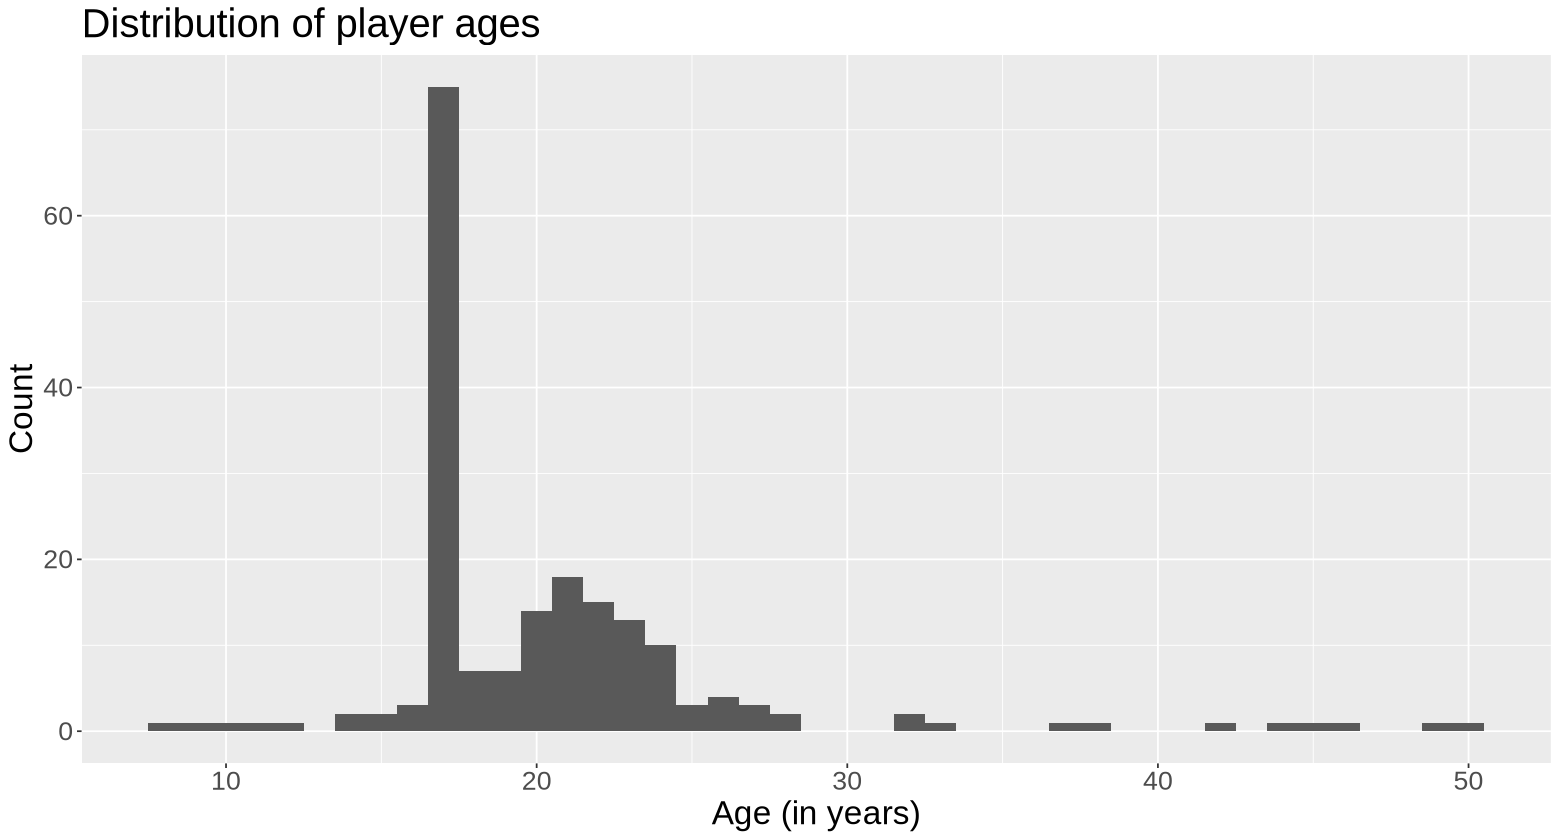

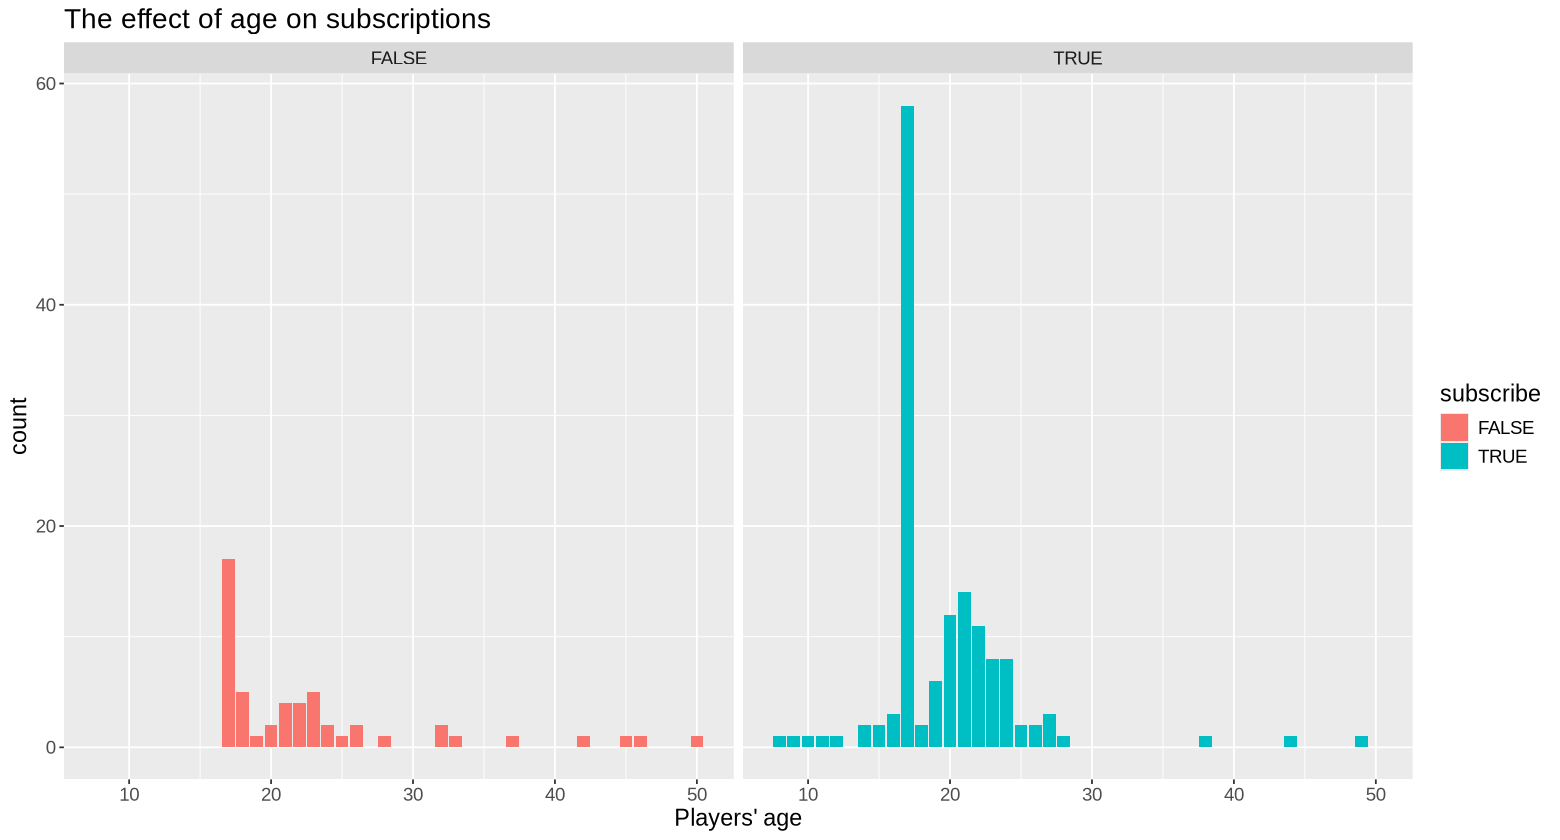

In [6]:
options(repr.plot.width = 13, repr.plot.height = 7)

# Visualization1: Distribution of ages 
age_plot <- player_data |>
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 1) +
    labs(y = "Count", x = "Age (in years)", title = "Distribution of player ages") +
    theme(text = element_text(size = 20))

age_plot

# Visualization2: How players' age effect the subscription
age_effect <- ggplot(players, aes(x=Age, fill=subscribe))+
                   geom_bar(state = identity) +
                   facet_grid(cols = vars(subscribe)) +
                   labs(x = "Players' age") +
                   ggtitle("The effect of age on subscriptions") +
                   theme(text = element_text(size = 14),
                         legend.position = "right",
                         legend.direction = "vertical")
age_effect

The exploratory visualizations indicate that the general playerbase is between 10 and 30 years old. It also shows there is a preference for older players to subscribe to the newsletter.

Warning message in scale_y_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”


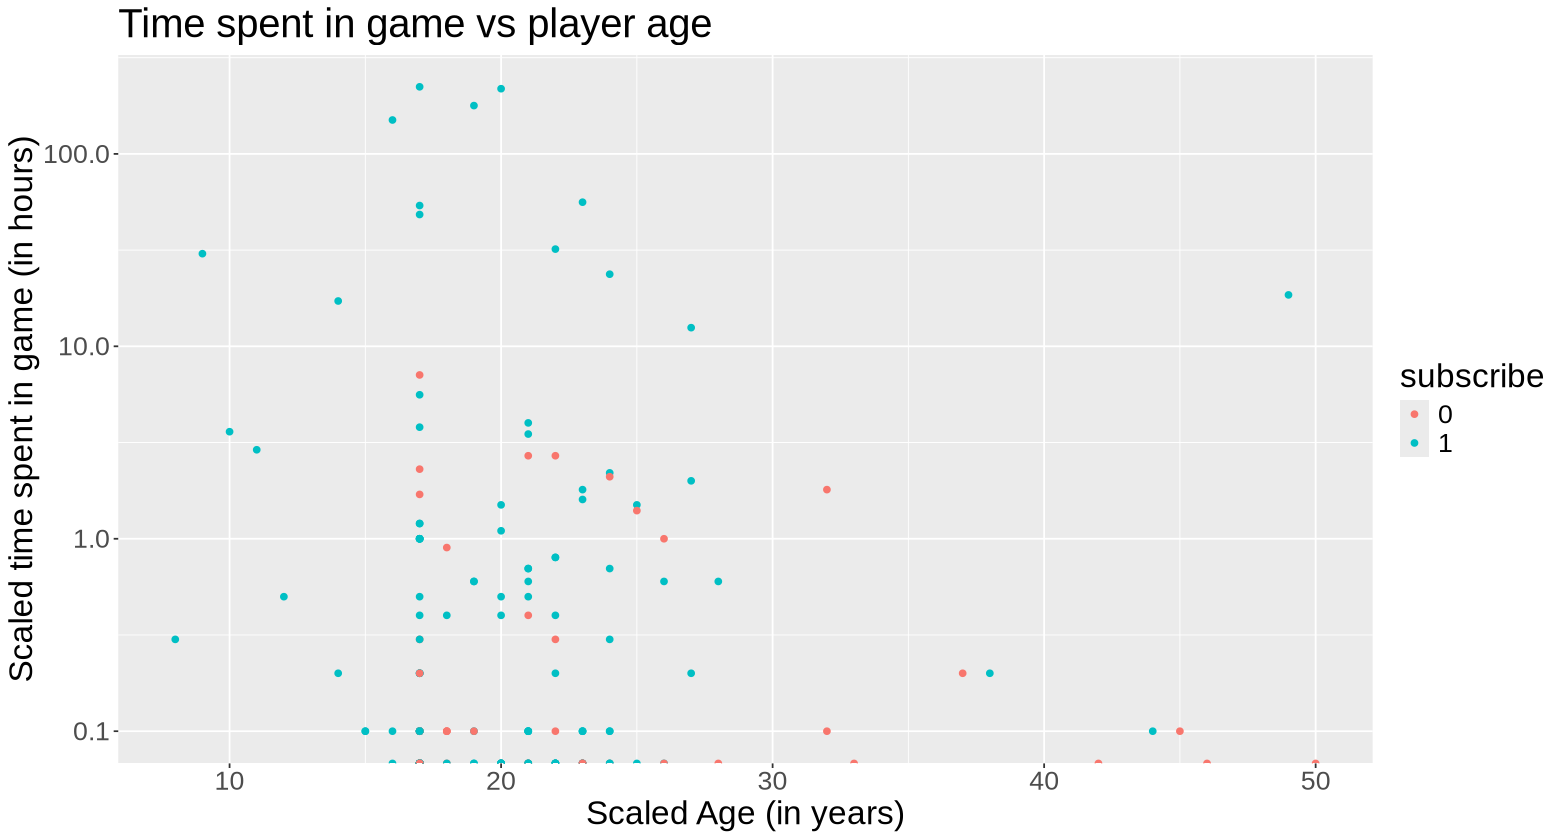

In [13]:
#Visualizaiton3: Plot of age and time spent in game
hours_and_age_plot <- player_data |>
    ggplot(aes(x = Age, y =played_hours, colour=subscribe)) +
    geom_point()+
    labs(y = "Scaled time spent in game (in hours)", x = "Scaled Age (in years)", title = "Time spent in game vs player age") +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 20)) 
    
hours_and_age_plot

This visualization indicates the time spent in the game vs. player age for the dataset. Generally, younger players, ages 15 to 30, tend to engage more heavily with the game than older age groups.

Warning message in geom_bar(state = identity):
“Ignoring unknown parameters: `state`”
Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_count()`).”


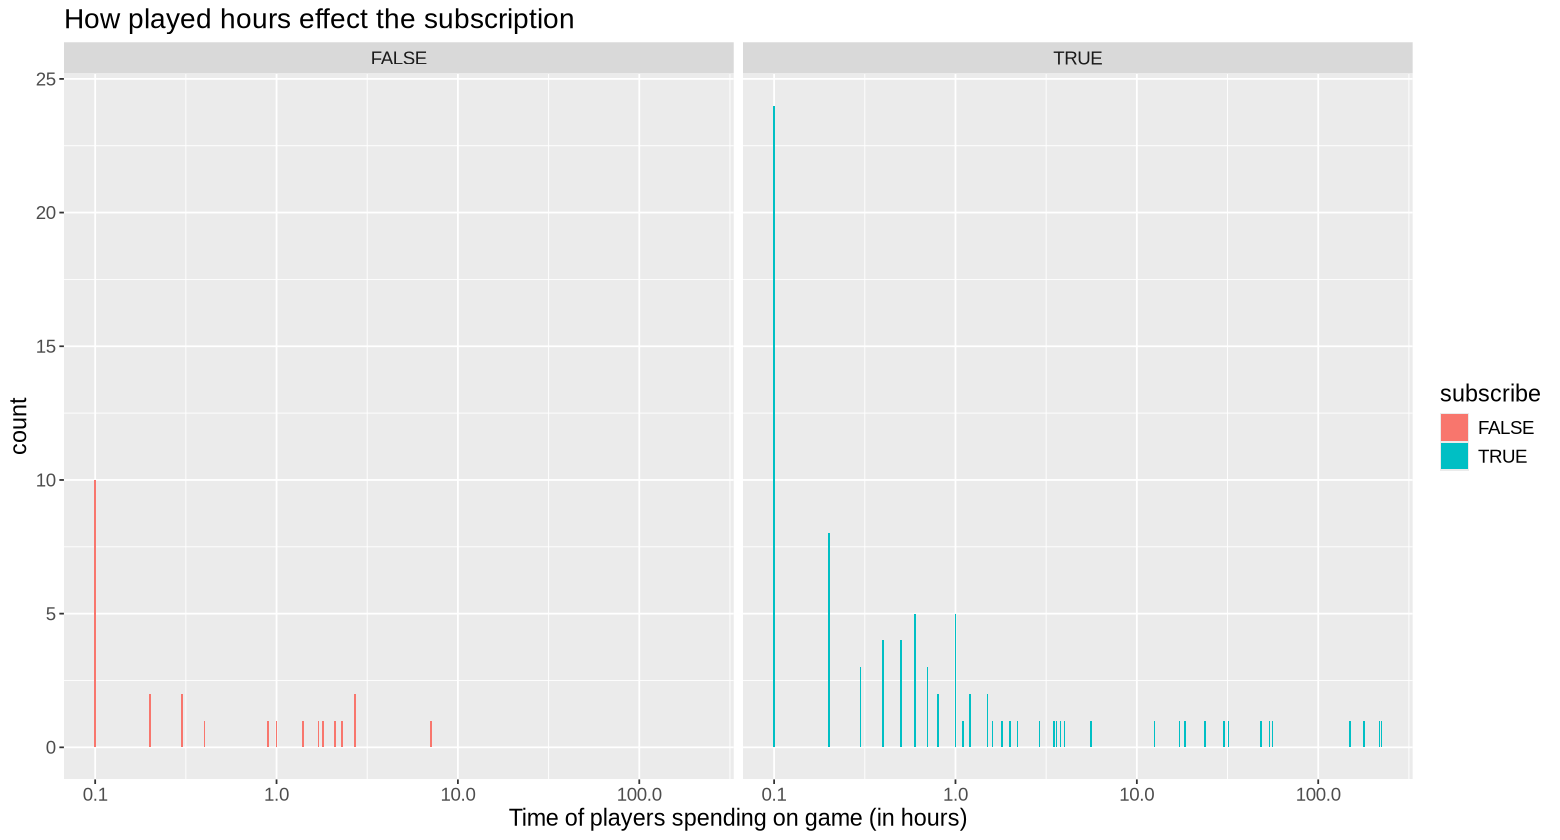

In [8]:
# Visualization4: How played hours effect the subscription
options(repr.plot.width = 13, repr.plot.height = 7)
hours_effect <- ggplot(players, aes(x=played_hours, fill=subscribe))+
                   geom_bar(state = identity) +
                   labs(x = "Time of players spending on game (in hours)") +
                   facet_grid(cols = vars(subscribe)) +
                   ggtitle("How played hours effect the subscription") +
                   theme(text = element_text(size = 14)) +
                   scale_x_log10(labels = label_comma())
hours_effect

This visualizations show the amount of hours players spend, and how it effects their subscriptions. It appears that generally players who spend longer in the game are more likely to subscribe. 

### Training Prediction Model

Now that the data is wrangled and statistics have been calculated, this allows for the creation of the KNN classification model, the main goal of this project.

The main problem posed in this project, is a classification problem. This type of problem entails making predictions of the future depending on past data. (Timbers et al., 2022)

As such, a KNN classification model was selected as it met the needs for predicting if a player would or would not subscribe to the game newsletter. `Age` and `played_hours` will be used as predictors, while `subscribe` will be used as the predicted class., a prediction of `1` would mean they have subscribed, while a prediciton of `0` would mean they have not.

In [9]:
## Splitting training and testing datasets
set.seed(2025)

player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)  
player_training <- training(player_split)
player_testing <- testing(player_split)

This operation splits the dataset into a seperate and training set, with 75% of the dataset being reserved for training a model, while the rest of reserved for testing the model. This is done to ensure the model is given fresh data when testing to make sure it can be accruately evaluated. (Timbers et al., 2022) In the same way somebody wouldn't study with the answers open, if the whole dataset is used to train the model, then its performance cannot be evaluated effectively as it is designed to know the answers. 

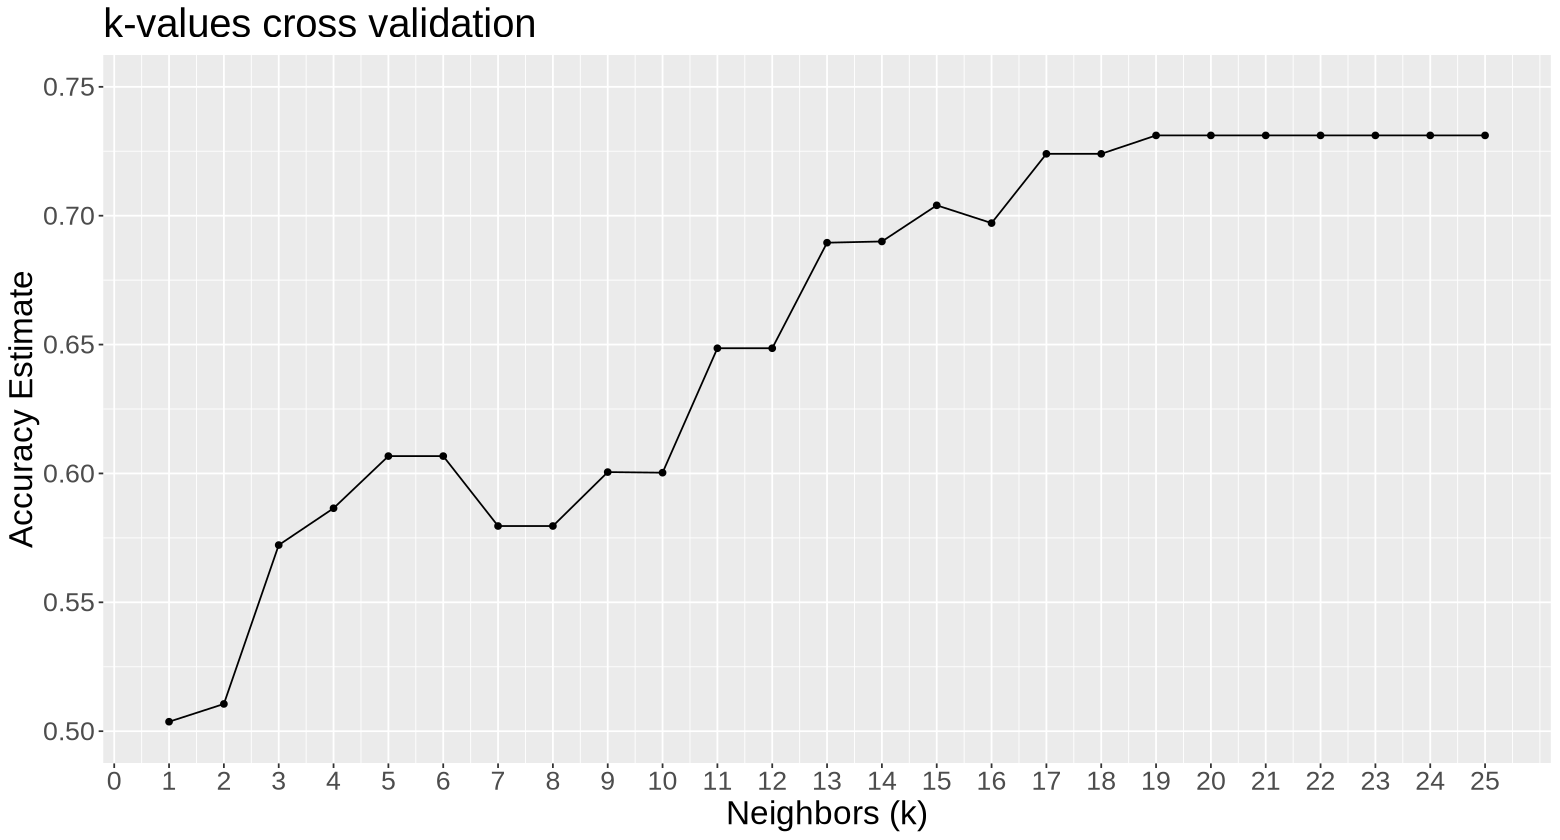

In [10]:
## Testing and cross-validation for N value
set.seed(2025)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))
player_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = player_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- player_results |>
     filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors (k)", y = "Accuracy Estimate")+
      ggtitle("k-values cross validation") +
      scale_x_continuous(breaks = seq(0, 25, by = 1)) + 
      scale_y_continuous(limits = c(0.5, 0.75)) +
      theme(text = element_text(size = 20))

        
    
cross_val_plot

After the data is split, it is then preprocessed, which standardizes the training data. This is done as the scale of each variable (the impact it has on making the prediction) will have a great effect on the model. By centering and scaling, it will ensure the impact of each variable is equal to each other, accurately depicting the relationships. 

Now, cross validation is performed. This is a process where the training set is further subdivided into training and validation sets. Once split, the model will be trained with varying K values (Timbers et al., 2022).  After training each model, the accuracy metrics are recorded and displayed in a graph. This graph shows the performance of each K value. 

The graph indicates anything from 19 and onwards will provide the greatest accuracy, as such, we will be selecting 19 as the candidate for K. However, it should be noted that the model behaviour is abnormal. As K increases, there is a point where the accuracy should decrease. This is due to overfitting and underfitting of the model and any data points (underfitting means the model isn’t influenced enough by the data, while overfitting means the model is influenced too much by the data). As this behaviour is not seen, this can indicate that there may be better model for prediction compared to using KNN. 

After selecting K, the final model can be trained with the acquired K value. After training, the testing set is then used to gauge the accuracy of the predictions of the model. 

In [11]:
## Setting parameters for the final model

knn_spec_cv <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
      set_engine("kknn") |>
      set_mode("classification")

player_fit <- knn_spec_cv |> 
       fit(subscribe ~ played_hours + Age, data = player_training)

player_predictions <- predict(player_fit, player_testing) |>
      bind_cols(player_testing)

player_metrics <- player_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)  
player_metrics

player_conf_mat <- player_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class)
player_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612
kap,binary,-0.1426612


          Truth
Prediction  0  1
         0  0  4
         1 13 32

In [12]:
new_obs <- tibble(Age = 33, played_hours = 15)

prediction <- predict(player_fit, new_obs)
prediction

.pred_class
<fct>
1


A simulated new player, aged 33 with 15 hours of gameplay, is predicted to subscribe to the newsletter according to the fitted KNN predictive model.

## 3. Discussion

### Result Summary

- The confusion matrix shows the model has made 4 false negatives, and 13 false positive predictions. It also shows that it did not predict a single true negative (players that were not subscribed). The remaining 32 entries in the dataset were predicted accurately being true positives. 
- The accuracy of the model is determined during the process of building a classification model. The accuracy is found to be 0.653, which indicates a 65.3% of successful rate on predicting the subscriber status from age and played hours. This is quite low, and could be indicative of many underlying issues.


### Expected findings

- The expected findings would’ve been a clear relationship between `hours_played`, `Age` and the likelihood of subscribing to the newsletter (`subscribe`).
- It was expected older players, who have played for longer would’ve had a higher rate of subscribing to the newsletter, this expectation was made after the preliminary analysis.
- The results of the model seem to be inconclusive, as it had a large number of false positive readings with nearly 28% of the predictions being false positives. The model also fully failed to predict players who would’ve not subscribed to the newsletter. 

### Impact of the findings
- The model achieves an accuracy of 65.3%, suggesting that `Age` and `played_hours` provide some predictive signal for predicting `subscribe`. However, this level of accuracy is relatively low, indicating that while user engagement and age are relevant factors, they are not sufficient on their own to predict whether a user would subscribe or not.
- While `Age` and `played_hours` might be correlated with `subscribe`, they are not sufficient on their own to build a reliable predictive model. This suggests that it may need to incorporate more other features. There could also be a possibility where these predictors have little correlation with `subscribe` due to the low accuracy.
- The low accuracy may also be attributed to the nature of the dataset. As it is quite small, it may not have provided enough data for the model to be trained accurately. KNN prediction models require a massive amount of data for training before accurate results are produced. 

### Furture quesitons the result lead to
- The model was ineffective on predicting `subscribe` from  `Age` and `played_hours` with an accuracy of 65.3%. Insufficient data was one of the factors that has deviated the accuracy. Therefore, for future investigation, a larger data set could be utilized to build a more effective model on predicting  `subscribe`. 
- The findings emphasize that `subscribe` are influenced by more than just the age of user and usage time, revealing the complexity of subscription behavior. Future investigations should consider what other factors drive `subscribe` beyond `Age` and `played_hours`, such as psychological, social, and economic factors that may better explain why users choose to `subscribe` or not.

## 4. References

Timbers, T., Campbell, T., & Lee, M. (2022). Data Science. CRC Press.